## Time Series Dataset Prediction
Name: Mayank Vijay Kumar <br /> 
Roll No: 102097021  
Batch: CSE3


### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import RandomForestRegressor

### Importing Dataset 

In [2]:
df = pd.read_excel('DATASET.xlsx')

In [3]:
df

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,NaN,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,NaN,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,NaN,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,NaN,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


### Data Preprocessing

In [4]:
# Dropping section 92 because it only has 9 years of data instead of 10 which we need to predict on.
df = df.drop([910, 911, 912, 913, 914, 915, 916, 917, 918])   

In [5]:
#Providing each section with similar section name
j = 0
for i in range(100):
    df.iloc[j:j + 10, 0] = df.iloc[j, 0]
    j += 10

In [6]:
#Renaming first column
df.columns = df.columns.str.replace('Unnamed: 0', 'Section')

In [7]:
#Replacing empty cells with zero
df.fillna(0, inplace=True)

### Test Dataset

In [8]:
test_data = df.loc[df['year'] == 10]
test_data

,Section,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
9,Sec_1,10,324.0,53.6,19.0,0.0,2,105,7567,1885,16.8,105.0,65.0,9,1.960
19,Sec_2,10,327.7,62.0,22.7,0.0,2,102,30525,10234,76.5,44.3,5.0,9,0.795
29,Sec_3,10,487.7,93.2,22.5,0.0,4,110,2140,1270,78.5,0.0,0.0,16,1.432
39,Sec_4,10,543.6,93.2,22.5,0.0,4,110,2140,1270,28.5,60.5,67.0,11,2.004
49,Sec_5,10,434.4,149.0,11.7,72.0,3,110,13142,6225,0.0,276.2,34.0,6,1.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,Sec_97,10,514.0,1226.4,10.1,203.6,16,114,7672,303,219.7,206.2,10.0,8,1.607
978,Sec_98,10,901.0,1531.0,11.1,34.9,40,100,15150,1077,5.9,74.5,33.0,13,1.087
988,Sec_99,10,1181.0,1364.9,9.2,274.3,24,112,12500,880,131.4,72.4,18.0,12,0.996
998,Sec_100,10,662.0,1110.7,12.8,33.2,27,117,3324,1356,193.7,305.6,180.0,12,2.212


### Model Definition 

In [9]:
model = ExtraTreesRegressor(n_estimators=200,bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=1000,
                    min_impurity_decrease=0.0, 
                    min_samples_leaf=1,
                    min_weight_fraction_leaf=0.1,
                    n_jobs=None, oob_score=False, random_state=123, verbose=0,
                    warm_start=False)

In [10]:
predict_col_names = ['Para-9', 'Para-10', 'Para-11', 'Para-12', 'Para-13']

In [11]:
result = {'Para-9': [], 'Para-10': [], 'Para-11': [], 'Para-12': [], 'Para-13': []}

In [12]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

### Applying Model

In [13]:
def selectedModel(val):
    RMSE = []
    N = 0
    index = 0
    #For Applying ExtraTreesRegressor
    if(val==0):
        for j in [10, 11, 12, 13, 14]:
            ans = 0
            count = 0
            for i in range(0, 1000, 10):
                #Extracting Train and Test Data
                xtrain = df.iloc[i:i+9, 1:10]
                ytrain = df.iloc[i:i+9, j]
                xtest = df.iloc[i+9, 1:10].to_numpy()
                ytest = df.iloc[i+9, j]

                #Applying Random Forest 
                model.fit(xtrain, ytrain)

                #Predicting Values
                ypredict = model.predict(xtest.reshape(1,-1))[0]

                #Appending Results
                result[predict_col_names[index]].append(ypredict)
                ans += (ytest - ypredict)**2
                count += 1
                N += 1

            RMSE.append(ans)
            index += 1
            
    #For Applying Random Forest    
    else:
        for j in [10, 11, 12, 13, 14]:
            ans = 0
            count = 0
            for i in range(0, 1000, 10):
                #Extracting Train and Test Data
                xtrain = df.iloc[i:i+9, 1:10]
                ytrain = df.iloc[i:i+9, j]
                xtest = df.iloc[i+9, 1:10].to_numpy()
                ytest = df.iloc[i+9, j]

                #Applying Random Forest 
                rf.fit(xtrain, ytrain)

                #Predicting Values
                ypredict = rf.predict(xtest.reshape(1,-1))[0]

                #Appending Results
                result[predict_col_names[index]].append(ypredict)
                ans += (ytest - ypredict)**2
                count += 1
                N += 1

            RMSE.append(ans)
            index += 1
    return (RMSE, count)

In [14]:
#Applying Random Forest
res_RMSE, res_count = selectedModel(1)

### Prediction

In [15]:
prediction = pd.DataFrame.from_dict(result)
prediction

,Para-9,Para-10,Para-11,Para-12,Para-13
0,2.5015,53.0868,37.335,7.579,1.892430
1,56.0135,27.8117,0.885,7.610,0.788332
2,64.2127,0.0000,0.000,11.257,1.361942
3,15.9736,53.1660,57.167,6.998,1.797542
4,0.0000,247.1847,33.835,5.890,1.678023
...,...,...,...,...,...
95,163.9678,176.6288,8.830,7.289,1.503908
96,4.0836,57.8961,21.501,11.673,1.064197
97,96.5461,55.9914,12.140,10.738,0.889464
98,108.1926,223.4488,131.641,10.403,2.025848


### Root Mean Square Error 

In [16]:
#RMSE for each column
for i in res_RMSE:
    print((i/res_count)**0.5)

71.8394569632351
67.65406532896242
27.93363279191233
15.012399362526963
0.24423138889095777


In [17]:
res_RMSE

[516090.7576772506,
 457707.2555535514,
 78028.78409533999,
 22537.213461999996,
 5.964897131960624]

In [18]:
#Total RMSE
print((sum(res_RMSE)/500)**0.5)

46.35450303228963


### Plotting Result 

In [19]:
#Selecting random 30 rows
import random
ind = []
for i in range(30):
    ind.append(random.randint(0,100))

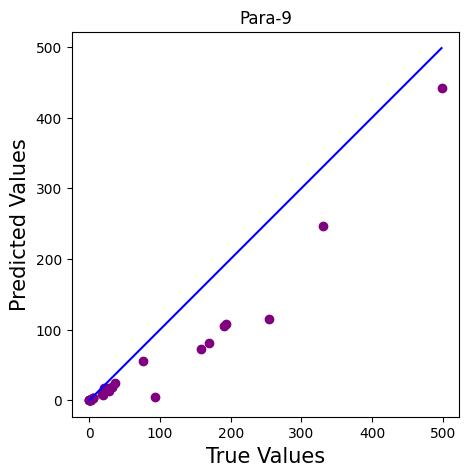

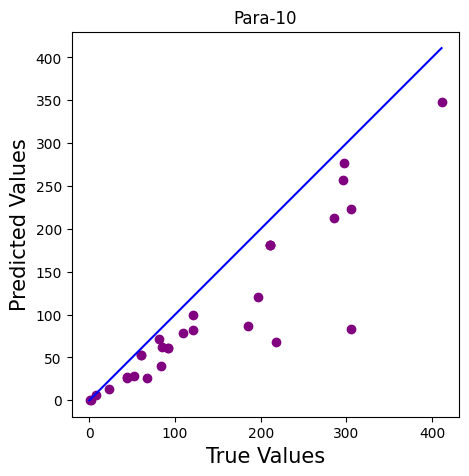

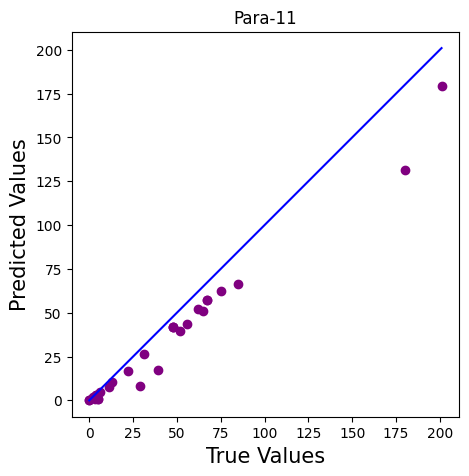

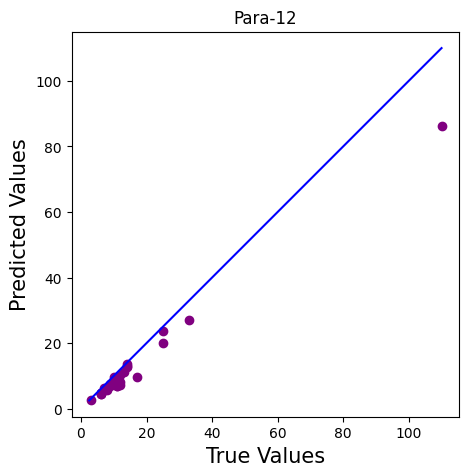

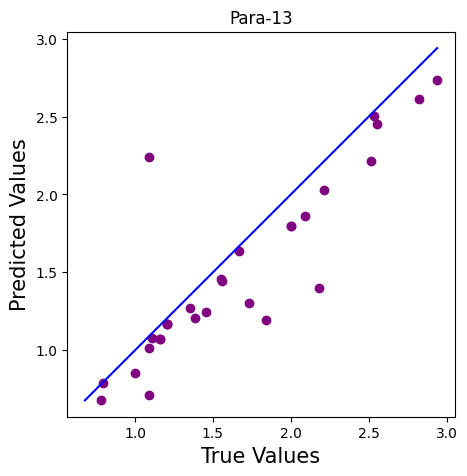

In [20]:
#Scatter plot for random 30 rows out of 100 for each target column
for i in range(5):
    plt.figure(figsize=(5,5))
    true_value = test_data.iloc[ind, i+10]
    predicted_value = prediction.iloc[ind, i]
    plt.scatter(true_value, predicted_value, c='purple')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title(predict_col_names[i])
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predicted Values', fontsize=15)
    plt.axis('equal')
    plt.show()